In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import h5py

In [2]:
# Referred to Midterm template, Sree's practice notebook and GPT
class BRATS2020Dataset(Dataset):
    """
    Dataset class for BRATS2020 .h5 files. 
    Assumes each .h5 file contains 'image' and 'mask' keys.
    """

    def __init__(self, root_dir, n_sample=None, image_size=(256, 256), mask_size=(256, 256)):
        """
        Args:
            root_dir (str): Root directory with .h5 files.
            n_sample (int, optional): Number of samples to use. Defaults to all.
            image_size (tuple): Target image size.
            mask_size (tuple): Target mask size.
        """
        self.root_dir = root_dir
        self.file_paths = sorted(glob.glob(os.path.join(root_dir, '*.h5')))

        if n_sample and n_sample < len(self.file_paths):
            self.file_paths = self.file_paths[:n_sample]

        self.n_sample = len(self.file_paths)

        # Define transforms
        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Resize(image_size),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        self.msk_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(mask_size, interpolation=transforms.InterpolationMode.NEAREST)
        ])

    def __len__(self):
        return self.n_sample

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as f:
            image = np.array(f['image'])  # Assume shape (H, W)
            mask = np.array(f['mask'])    # Assume shape (H, W, C) or (H, W)

            # Optional channel weighting (0.1 for background class) #GPT referred here
            if mask.ndim == 3:
                mask = np.concatenate([np.ones((*mask.shape[:2], 1)) * 0.1, mask], axis=-1)
                mask = np.argmax(mask, axis=-1)

        image = self.img_transform(image)
        mask = self.msk_transform(mask).squeeze(0).long()

        return {
            'image': image,
            'mask': mask,
            'filename': os.path.basename(file_path)
        }
        

In [3]:
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
dataset = BRATS2020Dataset(data_dir, n_sample=10000)

train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1- train_ratio - test_ratio
train_size = int(train_ratio * len(dataset)) 
val_size = int(test_ratio * len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch_size= 16
train_loader= DataLoader(train_dataset, batch_size= batch_size, shuffle= True)
val_loader= DataLoader(val_dataset, batch_size= batch_size, shuffle = False)
test_loader= DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [4]:
#UNet++ model: References: https://github.com/4uiiurz1/pytorch-nested-unet

class VGGBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class NestedUNet(nn.Module):
    def __init__(self, name, num_classes, input_channels, deep_supervision=False):
        super().__init__()
        self.name = name
        nb_filter = [32, 64, 128, 256, 512]
        self.deep_supervision = deep_supervision
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.final(x0_4)


In [5]:
# Initialize the model
input_channels = 4 
output_classes = 4  
my_NestedUNet = NestedUNet(name='My_DenseUNet',num_classes=output_classes, input_channels=input_channels, deep_supervision=True)
my_NestedUNet.cuda()

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
  

In [6]:
optimizer = torch.optim.Adam(my_NestedUNet.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [7]:
# Training Loop incorporating multiple output maps (Reference for handling the same: GPT)
# Define a function that computes the Jaccard score for binary segmentation
def dice_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    dices = []
    for cls in range(1, num_classes):  # skip background
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no pixels in both pred and GT
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum
        dice = (2 * inter + eps) / (union + eps)
        dices.append(dice.item())
    return np.mean(dices) if len(dices) > 0 else 0.0
    
# Define a function that computes the DICE score for binary segmentation
def jaccard_coeff_multiclass(y_pred, y_true, num_classes=4, eps=1e-6):
    jaccards = []
    for cls in range(1, num_classes):
        pred_cls = (y_pred == cls).float()
        true_cls = (y_true == cls).float()
        pred_sum = torch.sum(pred_cls)
        true_sum = torch.sum(true_cls)
        if pred_sum + true_sum == 0:
            continue  # skip class with no activity
        inter = torch.sum(pred_cls * true_cls)
        union = pred_sum + true_sum - inter
        jaccard = (inter + eps) / (union + eps)
        jaccards.append(jaccard.item())
    return np.mean(jaccards) if len(jaccards) > 0 else 0.0


def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    if not os.path.isdir(net.name):
        os.mkdir(net.name)

    train_loss, valid_loss = [], []
    train_dice, valid_dice = [], []
    train_jaccard, valid_jaccard = [], []

    for epoch in range(epochs):
        # ------------------ Training ------------------ #
        net.train()
        train_batch_loss, train_batch_dice, train_batch_jaccard = [], [], []

        for batch in train_dataloader:
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            outputs = net(imgs)  # outputs is a list: [out1, out2, out3, out4]

            # Loss: average over all outputs
            loss = sum(loss_function(output, true_masks) for output in outputs) / len(outputs)
            train_batch_loss.append(loss.item())

            # Predictions from final output
            pred_class = torch.argmax(outputs[-1], dim=1)

            dice = dice_coeff_multiclass(pred_class, true_masks)
            jaccard = jaccard_coeff_multiclass(pred_class, true_masks)

            train_batch_dice.append(dice)
            train_batch_jaccard.append(jaccard)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss.append(np.mean(train_batch_loss))
        train_dice.append(np.mean(train_batch_dice))
        train_jaccard.append(np.mean(train_batch_jaccard))

        # ------------------ Validation ------------------ #
        net.eval()
        valid_batch_loss, valid_batch_dice, valid_batch_jaccard = [], [], []

        with torch.no_grad():
            for batch in valid_dataloader:
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                outputs = net(imgs)
                loss = sum(loss_function(output, true_masks) for output in outputs) / len(outputs)
                valid_batch_loss.append(loss.item())

                pred_class = torch.argmax(outputs[-1], dim=1)
                dice = dice_coeff_multiclass(pred_class, true_masks)
                jaccard = jaccard_coeff_multiclass(pred_class, true_masks)

                valid_batch_dice.append(dice)
                valid_batch_jaccard.append(jaccard)

        valid_loss.append(np.mean(valid_batch_loss))
        valid_dice.append(np.mean(valid_batch_dice))
        valid_jaccard.append(np.mean(valid_batch_jaccard))

        print(f"[Epoch {epoch+1}] "
              f"Train Loss: {train_loss[-1]:.4f}, DICE: {train_dice[-1]:.4f}, Jaccard: {train_jaccard[-1]:.4f} || "
              f"Val Loss: {valid_loss[-1]:.4f}, DICE: {valid_dice[-1]:.4f}, Jaccard: {valid_jaccard[-1]:.4f}")

        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')

    return train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard


In [8]:
EPOCHS = 30
train_loss, train_dice, train_jaccard, valid_loss, valid_dice, valid_jaccard = train_net(my_NestedUNet, EPOCHS, train_loader, val_loader, optimizer, loss_function)

[Epoch 1] Train Loss: 0.1551, DICE: 0.2861, Jaccard: 0.2095 || Val Loss: 0.0378, DICE: 0.3874, Jaccard: 0.2803
[Epoch 2] Train Loss: 0.0189, DICE: 0.6336, Jaccard: 0.4977 || Val Loss: 0.0145, DICE: 0.6050, Jaccard: 0.4862
[Epoch 3] Train Loss: 0.0143, DICE: 0.6744, Jaccard: 0.5412 || Val Loss: 0.0163, DICE: 0.6617, Jaccard: 0.5249
[Epoch 4] Train Loss: 0.0122, DICE: 0.7169, Jaccard: 0.5852 || Val Loss: 0.0106, DICE: 0.6918, Jaccard: 0.5664
[Epoch 5] Train Loss: 0.0106, DICE: 0.7375, Jaccard: 0.6110 || Val Loss: 0.0097, DICE: 0.7711, Jaccard: 0.6489
[Epoch 6] Train Loss: 0.0097, DICE: 0.7658, Jaccard: 0.6421 || Val Loss: 0.0102, DICE: 0.7366, Jaccard: 0.6120
[Epoch 7] Train Loss: 0.0093, DICE: 0.7615, Jaccard: 0.6409 || Val Loss: 0.0086, DICE: 0.7762, Jaccard: 0.6574
[Epoch 8] Train Loss: 0.0085, DICE: 0.7885, Jaccard: 0.6704 || Val Loss: 0.0082, DICE: 0.7794, Jaccard: 0.6612
[Epoch 9] Train Loss: 0.0082, DICE: 0.8021, Jaccard: 0.6866 || Val Loss: 0.0074, DICE: 0.8224, Jaccard: 0.7141
[

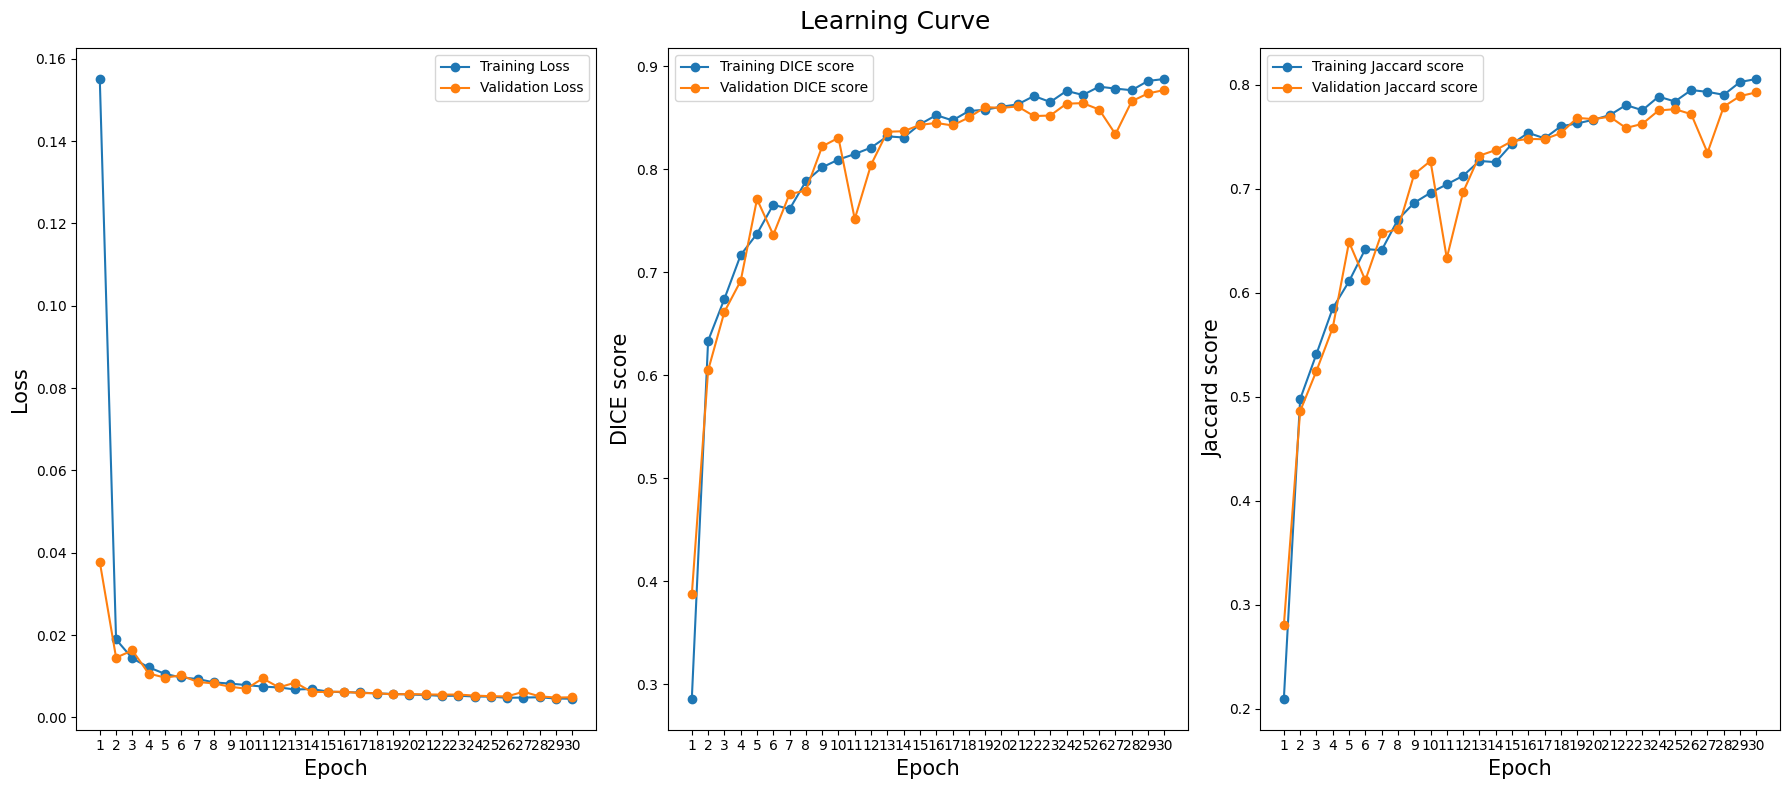

In [9]:
#Learning Curves
plt.figure(figsize=(18,8))
plt.suptitle('Learning Curve', fontsize=18)

plt.subplot(1,3,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,3,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(EPOCHS)+1, train_jaccard, '-o', label='Training Jaccard score')
plt.plot(np.arange(EPOCHS)+1, valid_jaccard, '-o', label='Validation Jaccard score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Jaccard score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch {best_epoch}')

state_dict = torch.load(f'./My_DenseUNet/epoch_{best_epoch:03}.pth')

best_model_path = f'./My_DenseUNet/epoch_{best_epoch:03}.pth'
torch.save(torch.load(best_model_path), './My_DenseUNet/best_model_30Epochs_UPP_May5.pth')

my_NestedUNet.load_state_dict(state_dict)
my_NestedUNet.cuda()

Best epoch is epoch 30


/tmp/ipykernel_31/2896734921.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'./My_DenseUNet/epoch_{best_epoch:03}.pth')
/tmp/ipykernel_31/28967

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
  

Sample batch "image" shape: torch.Size([16, 4, 256, 256])
Sample batch "mask" shape: torch.Size([16, 256, 256])
Predicted mask shape: torch.Size([16, 4, 256, 256])


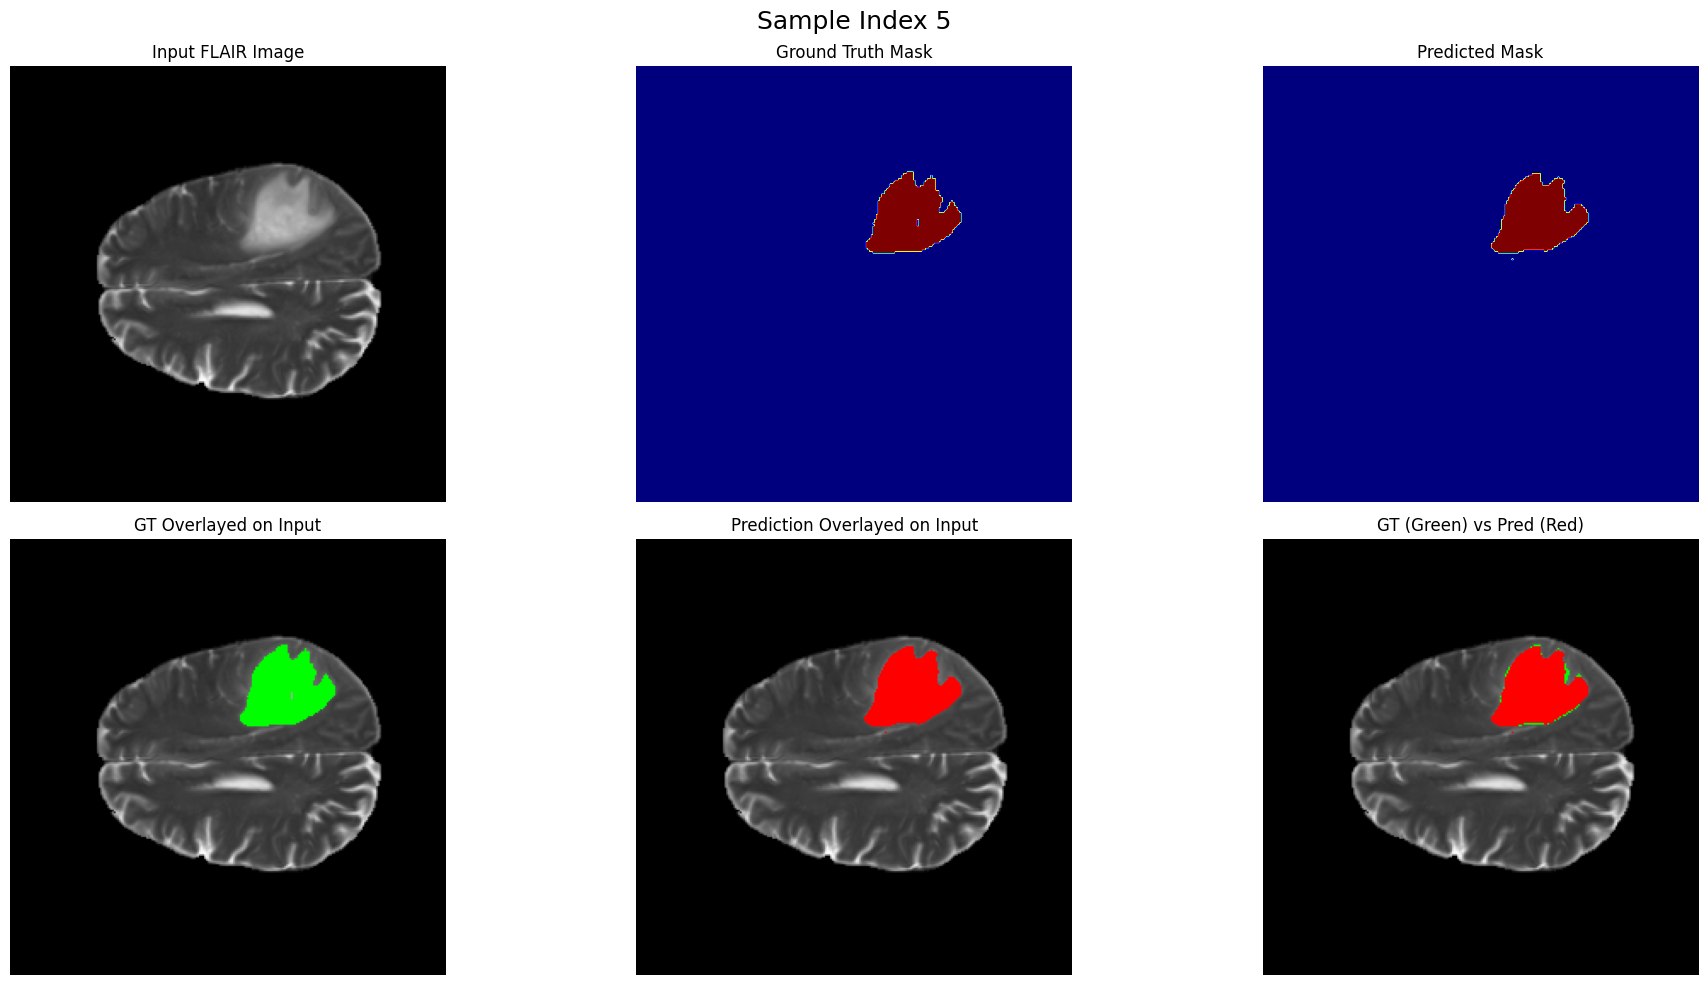

In [12]:
#Testing a sample
# Take the first batch of test set
for batch in test_loader:
    sample_batch = batch
    break

# Generate network prediction
with torch.no_grad():
    outputs = my_NestedUNet(sample_batch['image'].cuda())
    y_pred = outputs[-1]

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Predicted mask shape:', y_pred.shape)

# Select the index within the batch to visualize
i = 5  # or any other index in the batch

# Extract FLAIR modality (channel 3) of the i-th image
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
img = (img * 255).astype('uint8')  # Convert for visualization

# Ground truth mask
msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  # Binary version

# Prediction mask
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255  # Binary version

# Overlay masks on input image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  # Green for GT

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  # Red for prediction

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

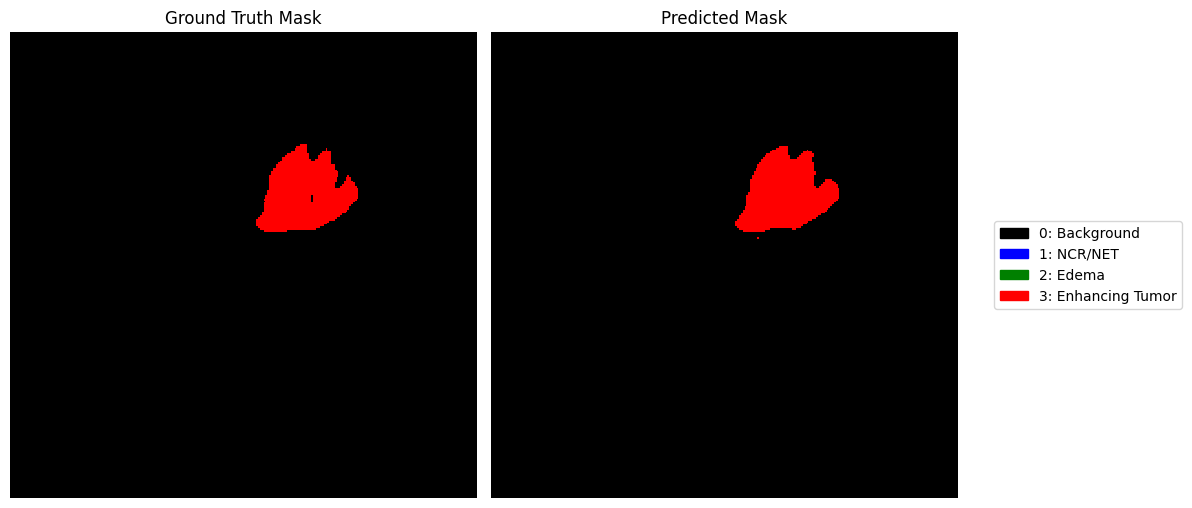

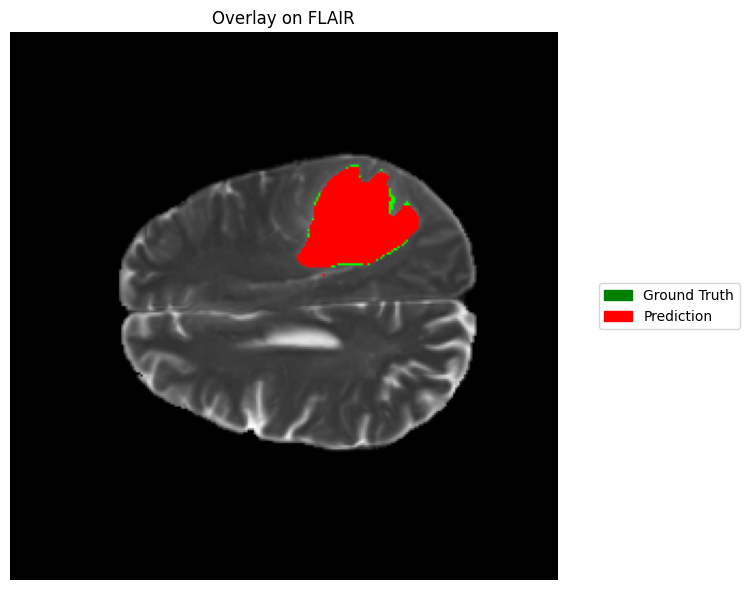

In [13]:
#Separate plots
# Extract file ID from full filename
filename = sample_batch['filename'][i]  # e.g., 'volume_001_slice_119.h5'
base_name = os.path.splitext(os.path.basename(filename))[0]  # removes .h5

#1
save_seg_path = f"/kaggle/working/{base_name}_segmask.png"
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# BraTS colormap (mapped class indices: 0,1,2,3)
cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])

# Retrieve filename
filename = sample_batch['filename'][i]

plt.figure(figsize=(12, 6))
# plt.suptitle(f'[{filename}] - Ground Truth vs Predicted Mask', fontsize=14)

plt.subplot(1, 2, 1)
plt.imshow(msk, cmap=cmap_seg, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_class, cmap=cmap_seg, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='3: Enhancing Tumor'),
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=1, fontsize=10)

plt.tight_layout()
plt.savefig(save_seg_path, dpi=300, bbox_inches='tight')
plt.show()

#2
save_overlay_path = f"/kaggle/working/{base_name}_overlay.png"
plt.figure(figsize=(10, 6))
# plt.suptitle(f'[{filename}] - Overlay: Ground Truth (Green) vs Prediction (Red)', fontsize=14)

plt.imshow(overlay_both)
plt.title('Overlay on FLAIR')
plt.axis('off')

legend_overlay = [
    Patch(color='green', label='Ground Truth'),
    Patch(color='red', label='Prediction')
]
plt.legend(handles=legend_overlay, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=1, fontsize=10)

plt.tight_layout()
plt.savefig(save_overlay_path, dpi=300, bbox_inches='tight')
plt.show()


In [14]:
#Testing Loop
def test_net(net, test_dataloader, loss_function, save_dir='/kaggle/working/pred_mask', class_labels=[0, 1, 2, 4]):
    import os
    from sklearn.metrics import confusion_matrix, accuracy_score

    os.makedirs(save_dir, exist_ok=True)
    
    net.eval()
    
    test_batch_loss = []
    test_batch_dice = []
    test_batch_jaccard = []
    test_batch_accuracy = []
    test_batch_CM = []

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            imgs = batch['image'].cuda()             # [B, 4, H, W]
            true_masks = batch['mask'].cuda()        # [B, H, W]
            filenames = batch.get('filename', [f'{i}_{j}.png' for j in range(imgs.shape[0])])  # fallback

            # Forward pass
            y_pred = net(imgs)
            if isinstance(y_pred, list):             # If deep supervision
                y_pred = y_pred[-1]                  # Use final output: [B, C, H, W]

            # Loss
            loss = loss_function(y_pred, true_masks)
            test_batch_loss.append(loss.item())

            # Predictions
            pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  # [B, H, W]

            # DICE & Jaccard (multiclass)
            dice = dice_coeff_multiclass(pred_class, true_masks)
            jaccard = jaccard_coeff_multiclass(pred_class, true_masks)
            test_batch_dice.append(dice)
            test_batch_jaccard.append(jaccard)

            # Accuracy & Confusion Matrix
            flat_true = true_masks.view(-1).cpu().numpy()
            flat_pred = pred_class.view(-1).cpu().numpy()
            acc = accuracy_score(flat_true, flat_pred)
            cm = confusion_matrix(flat_true, flat_pred, labels=class_labels, normalize='true')

            test_batch_accuracy.append(acc)
            test_batch_CM.append(cm)

            # Save predictions
            for k in range(pred_class.shape[0]):
                filename = os.path.splitext(os.path.basename(filenames[k]))[0]
                pred_np = pred_class[k].cpu().numpy().astype('uint8')
                save_path = os.path.join(save_dir, f'{filename}_pred.png')
                cv2.imwrite(save_path, pred_np)

            # Progress
            print(f'[TEST] Batch {i+1}/{len(test_dataloader)} - Loss: {loss.item():.4f}, Dice: {dice:.4f}, Jaccard: {jaccard:.4f}, Acc: {acc:.4f}', end='\r')

    # Aggregate metrics
    test_loss = np.mean(test_batch_loss)
    test_dice = np.mean(test_batch_dice)
    test_jaccard = np.mean(test_batch_jaccard)
    test_accuracy = np.mean(test_batch_accuracy)
    test_CM = np.mean(test_batch_CM, axis=0)

    return test_loss, test_dice, test_jaccard, test_accuracy, test_CM


In [15]:
#Test
test_loss, test_dice, test_jaccard, test_accuracy, test_CM = test_net(my_NestedUNet, test_loader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test Jaccard score: {test_jaccard}, Test overall accuracy: {test_accuracy}')

Test Loss: 0.003703098965808749, Test DICE score: 0.8833849987983704, Test Jaccard score: 0.7986988412340482, Test overall accuracy: 0.9985299682617188


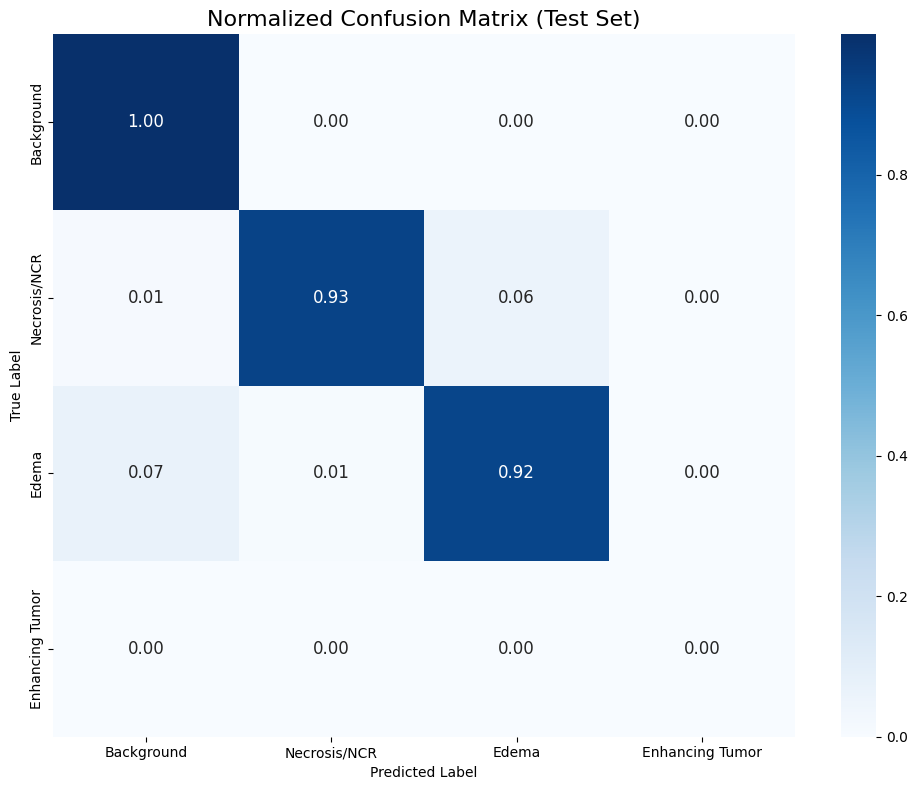

In [16]:
#CF Matrix
# BraTS label meaning
class_labels = [0, 1, 2, 4]
class_names = ['Background', 'Necrosis/NCR', 'Edema', 'Enhancing Tumor']

# Create confusion matrix DataFrame
df_cm = pd.DataFrame(test_CM, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues', annot_kws={"size": 12})
plt.title('Normalized Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channel = 4
output_channel = 4

# Step 1: Create the model
best_model = NestedUNet(name='My_DenseUNet',num_classes=output_classes, input_channels=input_channels, deep_supervision=True)
best_model.to(device)

# Step 2: Load weights into it
state_dict = torch.load("/kaggle/input/best-model-upp/best_model_30Epochs_UPP_May5.pth", map_location=device)
best_model.load_state_dict(state_dict)

# Step 3: Set to eval mode
best_model.eval()


/tmp/ipykernel_31/2155276997.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/best-model-upp/best_model_30Epochs_UPP_May5.pth", ma

NestedUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): VGGBlock(
    (relu): ReLU(inplace=True)
  

Sample batch "image" shape: torch.Size([16, 4, 256, 256])
Sample batch "mask" shape: torch.Size([16, 256, 256])
Predicted mask shape: torch.Size([16, 4, 256, 256])


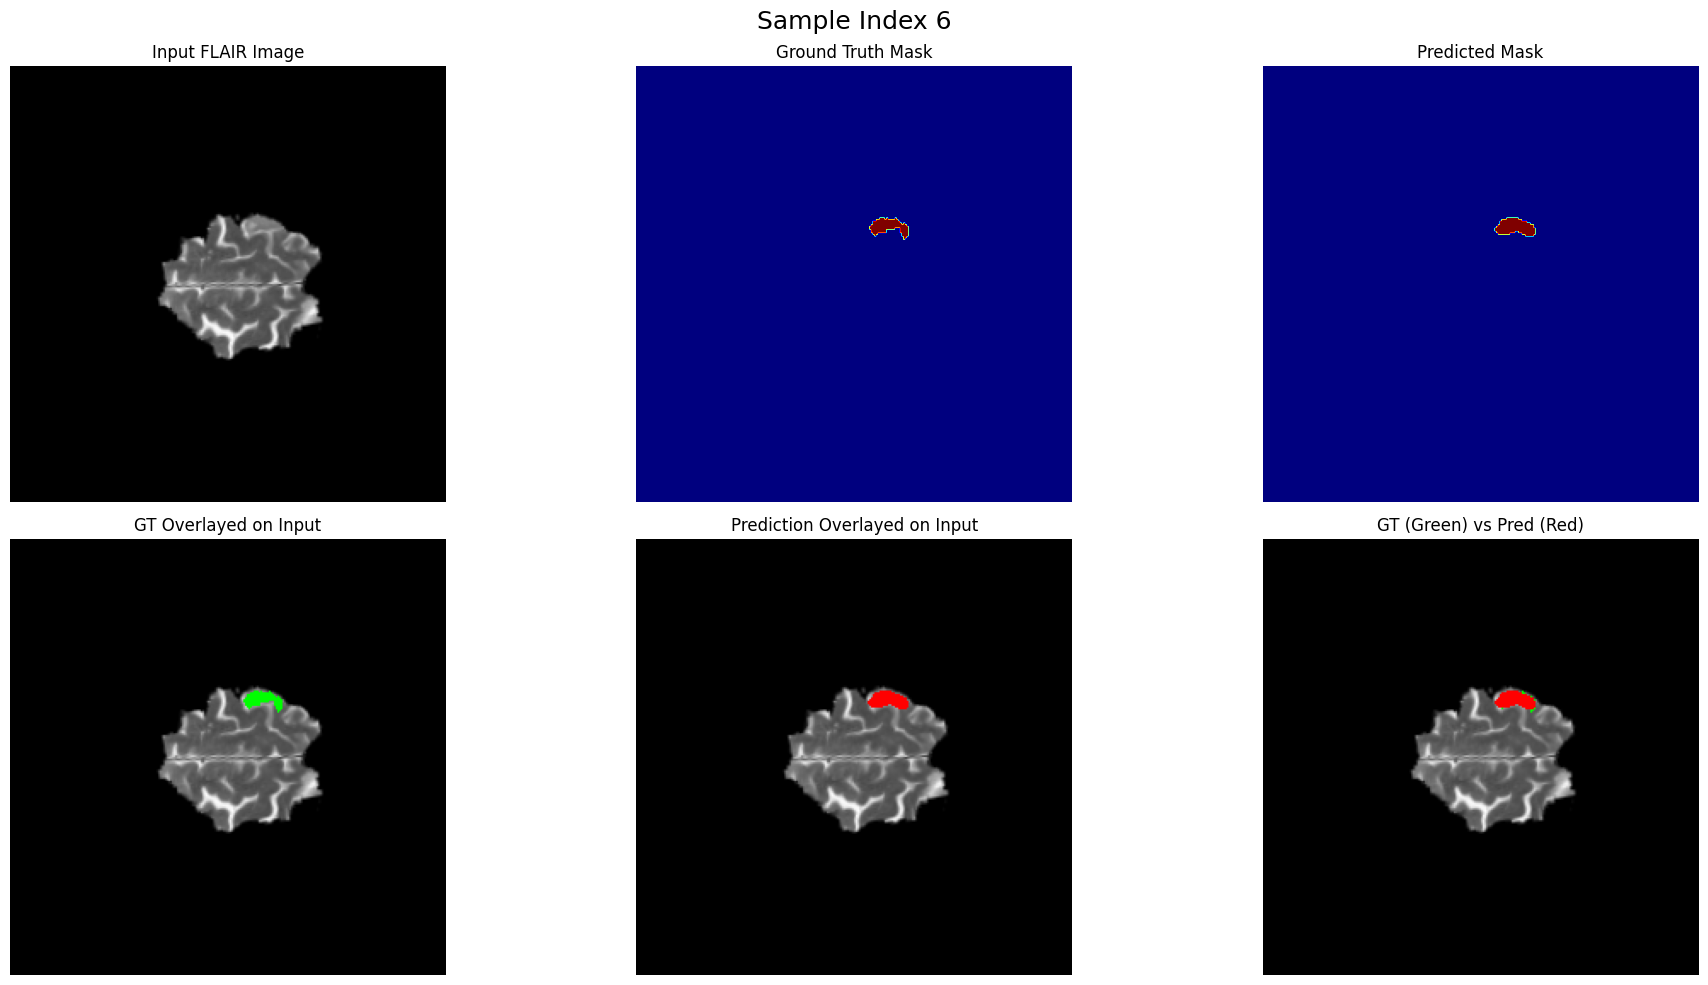

In [16]:
#Eval best model
#Test best model after loading
# Take the second batch of test set
i= 0
for batch in test_loader:
    sample_batch = batch
    if i == 2:
        break
    i+=1

# Generate network prediction
with torch.no_grad():
    outputs = best_model(sample_batch['image'].cuda())
    y_pred = outputs[-1]

# Print the shapes of the images, masks, predicted masks
print('Sample batch "image" shape:', sample_batch['image'].shape)
print('Sample batch "mask" shape:', sample_batch['mask'].shape)
print('Predicted mask shape:', y_pred.shape)

# Select the index within the batch to visualize
i = 6  # or any other index in the batch

# Extract FLAIR modality (channel 3) of the i-th image
img = sample_batch['image'][i, 3].cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
img = (img * 255).astype('uint8')  # Convert for visualization

# Ground truth mask
msk = sample_batch['mask'][i].cpu().numpy()
msk_vis = (msk > 0).astype('uint8') * 255  # Binary version

# Prediction mask
pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)[i].cpu().numpy()
pred_vis = (pred_class > 0).astype('uint8') * 255  # Binary version

# Overlay masks on input image
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
overlay_gt = img_rgb.copy()
overlay_gt[msk_vis == 255] = [0, 255, 0]  # Green for GT

overlay_pred = img_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]  # Red for prediction

overlay_both = img_rgb.copy()
overlay_both[msk_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# Plot the results
plt.figure(figsize=(20, 10))
plt.suptitle(f'Sample Index {i}', fontsize=18)

plt.subplot(2, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Input FLAIR Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(msk, cmap='jet')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(pred_class, cmap='jet')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(overlay_gt)
plt.title('GT Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(overlay_pred)
plt.title('Prediction Overlayed on Input')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(overlay_both)
plt.title('GT (Green) vs Pred (Red)')
plt.axis('off')

plt.tight_layout()
plt.show()

Predicted mask shape: torch.Size([1, 4, 256, 256])


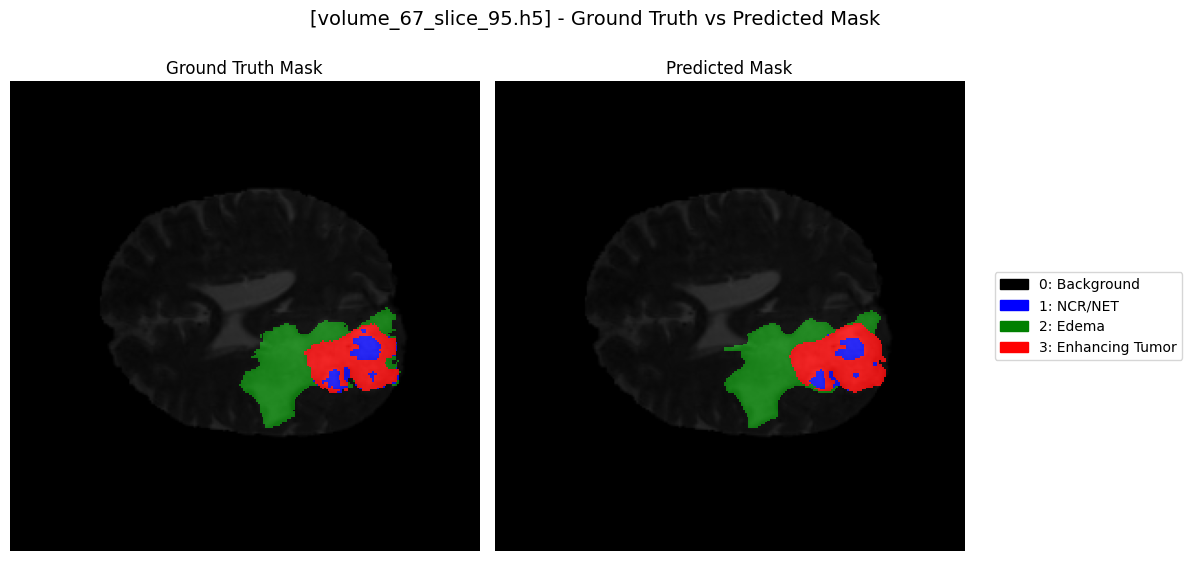

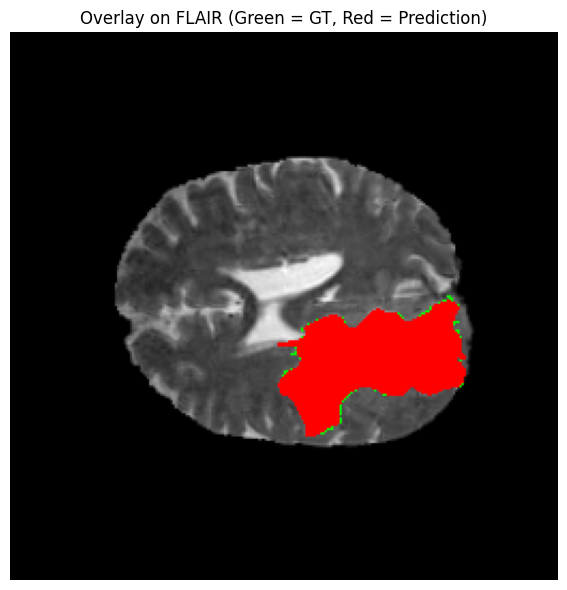

In [25]:
#Testing one particular image:
import torch
import torchvision.transforms as transforms
import cv2
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import os

# Load the file
file_path = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_67_slice_95.h5"
with h5py.File(file_path, 'r') as f:
    img_data = np.array(f['image'])        # (240, 240, 4)
    mask_data = np.array(f['mask'])        # (240, 240) or (240, 240, 3)

# --- Apply Dataset-style preprocessing ---

# Image transform
img_transform = transforms.Compose([
    transforms.ToTensor(),  # → (C, H, W), scaled [0, 1]
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5], std=[0.5])  # → [-1, 1]
])

# Mask transform
msk_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

# Handle mask shape
if mask_data.ndim == 3:
    mask_data = np.concatenate([np.ones((*mask_data.shape[:2], 1)) * 0.1, mask_data], axis=-1)
    mask_data = np.argmax(mask_data, axis=-1)

# Apply transforms
img_tensor = img_transform(img_data)         # shape: (4, 256, 256)
mask_tensor = msk_transform(mask_data).squeeze(0).long()  # shape: (256, 256)

# Inference
input_tensor = img_tensor.unsqueeze(0).cuda()  # (1, 4, 256, 256)
best_model.eval()
with torch.no_grad():
    outputs = best_model(input_tensor)
    y_pred = outputs[-1]
    print('Predicted mask shape:', y_pred.shape)
    pred_class = torch.argmax(torch.softmax(y_pred[0], dim=0), dim=0).cpu().numpy()
    

gt_mask = mask_tensor.numpy()

# --- Visualize on FLAIR channel (channel 3) ---
flair = img_data[:, :, 3]
flair = cv2.resize(flair, (256, 256))
flair_img = ((flair - flair.min()) / (flair.max() - flair.min()) * 255).astype('uint8')
flair_rgb = cv2.cvtColor(flair_img, cv2.COLOR_GRAY2RGB)

# Binary masks
gt_vis = (gt_mask > 0).astype('uint8') * 255
pred_vis = (pred_class > 0).astype('uint8') * 255

# Overlays
overlay_gt = flair_rgb.copy()
overlay_gt[gt_vis == 255] = [0, 255, 0]

overlay_pred = flair_rgb.copy()
overlay_pred[pred_vis == 255] = [255, 0, 0]

overlay_both = flair_rgb.copy()
overlay_both[gt_vis == 255] = [0, 255, 0]
overlay_both[pred_vis == 255] = [255, 0, 0]

# --- Plot results ---
filename = os.path.basename(file_path)

# Plot 1: Segmentation masks
plt.figure(figsize=(12, 6))
plt.suptitle(f'[{filename}] - Ground Truth vs Predicted Mask', fontsize=14)

cmap_seg = ListedColormap(['black', 'blue', 'green', 'red'])  # For labels 0-3

plt.subplot(1, 2, 1)
plt.imshow(flair_img,cmap='gray')
plt.imshow(gt_mask, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(flair_img,cmap='gray')
plt.imshow(pred_class, cmap=cmap_seg, alpha=0.8, interpolation='none')
plt.title('Predicted Mask')
plt.axis('off')

legend_patches = [
    Patch(color='black', label='0: Background'),
    Patch(color='blue', label='1: NCR/NET'),
    Patch(color='green', label='2: Edema'),
    Patch(color='red', label='3: Enhancing Tumor'),
]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/UPP_pred_sep.png')
plt.show()

# Plot 2: Overlay
plt.figure(figsize=(6, 6))
# plt.suptitle(f'[{filename}] - Overlay: GT (Green) vs Prediction (Red)', fontsize=14)
plt.imshow(overlay_both)
plt.title("Overlay on FLAIR (Green = GT, Red = Prediction)")
plt.axis('off')

legend_overlay = [
    Patch(color='green', label='Ground Truth'),
    Patch(color='red', label='Prediction')
]
# plt.legend(handles=legend_overlay, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
plt.tight_layout()
plt.savefig('/kaggle/working/UPP_pred.png')
plt.show()
